## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
from fastai.plots import *

In [10]:
from pycocotools.coco import COCO

In [5]:
PATH = Path('../data/coco/')

In [6]:
ls {PATH}

annotations/    hotdogs_valid/      person_mask_val/  val2017/
deploy_models/  models/             tmp/
hotdogs_train/  person_mask_train/  train2017/


## Multi-label versus single-label classification

## Multi-label models for Planet dataset

In [11]:
coco_trn = COCO(PATH/'annotations/instances_train2017.json')
coco_val = COCO(PATH/'annotations/instances_val2017.json')

loading annotations into memory...
Done (t=104.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!


In [12]:
all_img_ids_trn = coco_trn.getImgIds()
all_img_ids_val = coco_val.getImgIds()

In [20]:
for imx in all_img_ids_trn:
    im_ob = coco_trn.loadImgs(imx)[0]
    anns = coco_trn.loadAnns(im_ob['id'])
    print(anns)
    break

KeyError: 391895

In [19]:
im_ob

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895}]

In [8]:
arch = resnet34

In [6]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [7]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [9]:
data = get_data(256)

In [35]:
x,y = next(iter(data.val_dl))

In [36]:
y


    1     0     0  ...      0     1     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.FloatTensor of size 64x17]

In [37]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 1.0),
 ('water', 1.0)]

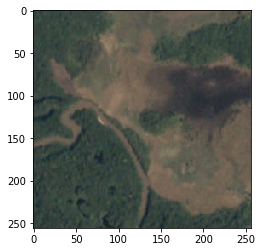

In [43]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [8]:
sz=64

In [9]:
data = get_data(sz)

In [10]:
data = data.resize(int(sz*1.3), 'tmp')

A Jupyter Widget

In [11]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

A Jupyter Widget

[ 0.       0.22404  0.31176  0.82044]                        



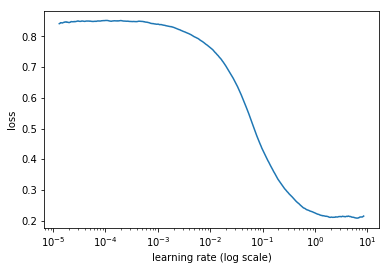

In [15]:
lrf=learn.lr_find()
learn.sched.plot()

In [12]:
lr = 0.2

In [13]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.14882  0.13552  0.87878]                        
[ 1.       0.14237  0.13048  0.88251]                        
[ 2.       0.13675  0.12779  0.88796]                        
[ 3.       0.13528  0.12834  0.88419]                        
[ 4.       0.13428  0.12581  0.88879]                        
[ 5.       0.13237  0.12361  0.89141]                        
[ 6.       0.13179  0.12472  0.8896 ]                        



In [14]:
lrs = np.array([lr/9,lr/3,lr])

In [15]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.12534  0.10926  0.90892]                        
[ 1.       0.12035  0.10086  0.91635]                        
[ 2.       0.11001  0.09792  0.91894]                        
[ 3.       0.1144   0.09972  0.91748]                        
[ 4.       0.11055  0.09617  0.92016]                        
[ 5.       0.10348  0.0935   0.92267]                        
[ 6.       0.10502  0.09345  0.92281]                        



In [19]:
learn.save(f'{sz}')

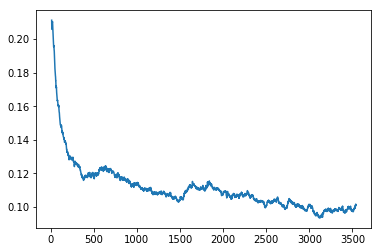

In [22]:
learn.sched.plot_loss()

In [20]:
sz=128

In [21]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09729  0.09375  0.91885]                         
[ 1.       0.10118  0.09243  0.92075]                         
[ 2.       0.09805  0.09143  0.92235]                         
[ 3.       0.09834  0.09134  0.92263]                         
[ 4.       0.096    0.09046  0.9231 ]                         
[ 5.       0.09584  0.09035  0.92403]                         
[ 6.       0.09262  0.09059  0.92358]                         



In [22]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.09623  0.08693  0.92696]                         
[ 1.       0.09371  0.08621  0.92887]                         
[ 2.       0.08919  0.08296  0.93113]                         
[ 3.       0.09221  0.08579  0.92709]                         
[ 4.       0.08994  0.08575  0.92862]                         
[ 5.       0.08729  0.08248  0.93108]                         
[ 6.       0.08218  0.08315  0.92971]                         



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [26]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [27]:
f2(preds,y)

0.93626519738612801

### End